In [2]:
import torch
torch.autograd.set_detect_anomaly(True)
import random
from tqdm import tqdm
import warnings
from metrics import *
warnings.filterwarnings("ignore")
import numpy as np
from diffusion import load_pretrained_DPM
import matplotlib.pyplot as plt
import torch.nn.functional as F
from data import get_datasets
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

def set_deterministic(seed):
    # seed by default is None 
    if seed is not None:
        print(f"Deterministic with seed = {seed}")
        random.seed(seed) 
        np.random.seed(seed) 
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True 
        torch.backends.cudnn.benchmark = False 
        warnings.warn('You have chosen to seed training. '
              'This will turn on the CUDNN deterministic setting, '
              'which can slow down your training considerably! '
              'You may see unexpected behavior when restarting '
              'from checkpoints.')

set_deterministic(31)

def pad_along_axis(array: np.ndarray, target_length: int, axis: int = 0) -> np.ndarray:

    pad_size = target_length - array.shape[axis]

    if pad_size <= 0:
        return array

    npad = [(0, 0)] * array.ndim
    npad[axis] = (0, pad_size)

    return np.pad(array, pad_width=npad, mode='constant', constant_values=0)

def eval_diffusion(window_size, EVAL_DATASETS, nT=10, batch_size=32, PATH="/tf/hsh/SW_ECG/PPG2ECG/", device="cuda"):

    _, dataset_test = get_datasets(datasets=EVAL_DATASETS, window_size=window_size)

    testloader = DataLoader(dataset_test, batch_size=batch_size, shuffle=True, num_workers=64)

    dpm, Conditioning_network1, Conditioning_network2 = load_pretrained_DPM(
        PATH=PATH,
        nT=nT,
        type="RDDM",
        device="cuda"
    )
    
    dpm = nn.DataParallel(dpm)
    Conditioning_network1 = nn.DataParallel(Conditioning_network1)
    Conditioning_network2 = nn.DataParallel(Conditioning_network2)

    dpm.eval()
    Conditioning_network1.eval()
    Conditioning_network2.eval()

    with torch.no_grad():

        fd_list = []
        fake_ecgs = np.zeros((1, 128*window_size))
        real_ecgs = np.zeros((1, 128*window_size))
        real_ppgs = np.zeros((1, 128*window_size))
        true_rois = np.zeros((1, 128*window_size))

        for y_ecg, x_ppg, ecg_roi in tqdm(testloader):

            x_ppg = x_ppg.float().to(device)
            y_ecg = y_ecg.float().to(device)
            ecg_roi = ecg_roi.float().to(device)

            generated_windows = []

            for ppg_window in torch.split(x_ppg, 128*4, dim=-1):
                
                if ppg_window.shape[-1] != 128*4:
                    
                    ppg_window = F.pad(ppg_window, (0, 128*4 - ppg_window.shape[-1]), "constant", 0)

                ppg_conditions1 = Conditioning_network1(ppg_window)
                ppg_conditions2 = Conditioning_network2(ppg_window)

                xh = dpm(
                    cond1=ppg_conditions1, 
                    cond2=ppg_conditions2, 
                    mode="sample", 
                    window_size=128*4
                )
                
                generated_windows.append(xh.cpu().numpy())

            xh = np.concatenate(generated_windows, axis=-1)[:, :, :128*window_size]

            fd = calculate_FD(y_ecg, torch.from_numpy(xh).to(device))

            fake_ecgs = np.concatenate((fake_ecgs, xh.reshape(-1, 128*window_size))) # fake y (만들어진 lead 2)
            real_ecgs = np.concatenate((real_ecgs, y_ecg.reshape(-1, 128*window_size).cpu().numpy())) # real y (lead 2)
            real_ppgs = np.concatenate((real_ppgs, x_ppg.reshape(-1, 128*window_size).cpu().numpy())) # real x (lead 1)
            true_rois = np.concatenate((true_rois, ecg_roi.reshape(-1, 128*window_size).cpu().numpy()))
            fd_list.append(fd)

            return fake_ecgs, real_ecgs, real_ppgs

        mae_hr_ecg, rmse_score = evaluation_pipeline(real_ecgs[1:], fake_ecgs[1:])

        tracked_metrics = {
            "RMSE_score": rmse_score,
            "MAE_HR_ECG": mae_hr_ecg,
            "FD": sum(fd_list) / len(fd_list),
        }

        return tracked_metrics


Deterministic with seed = 31


In [15]:
config = {
        "batch_size": 32,
        "nT": 10,
        "device": "cuda",
        "window_size": 4, # Seconds
        "eval_datasets": ["WESAD"]
    }

    # TABLE 1 results
print("\n******* Standard evaluation (Table 1) results *******")
    # for dataset_name in ["WESAD", "CAPNO", "DALIA", "BIDMC", "MIMIC-AFib"]:
for dataset_name in ["PTBXL"]:     
    fake_ecgs, real_ecg2, real_ecg1 = eval_diffusion(
        window_size=4,
        EVAL_DATASETS=[dataset_name],
        nT=10,
    )


******* Standard evaluation (Table 1) results *******


  0%|                                                                                                                                                                                                                                                                 | 0/273 [00:05<?, ?it/s]


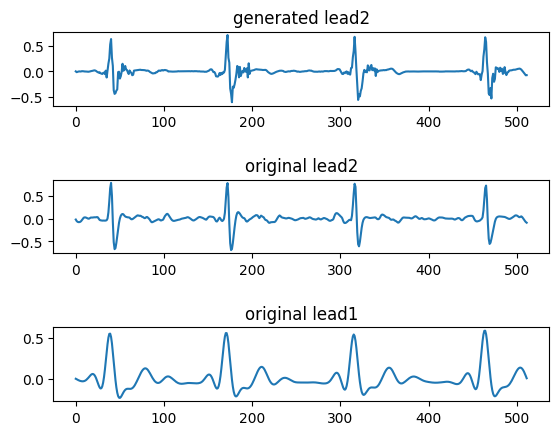

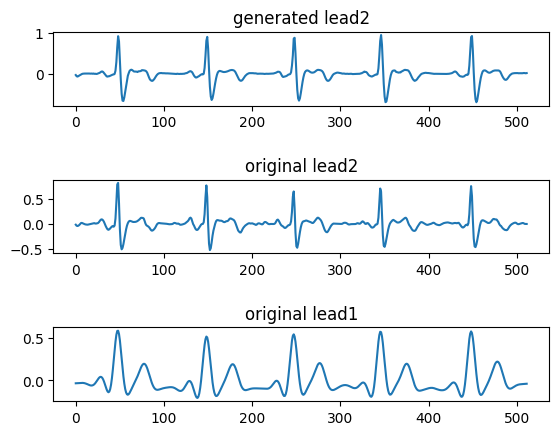

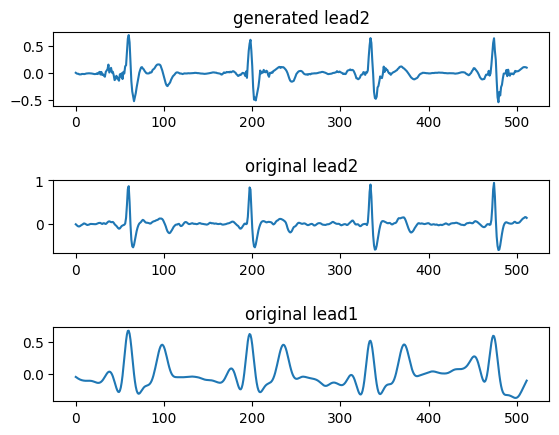

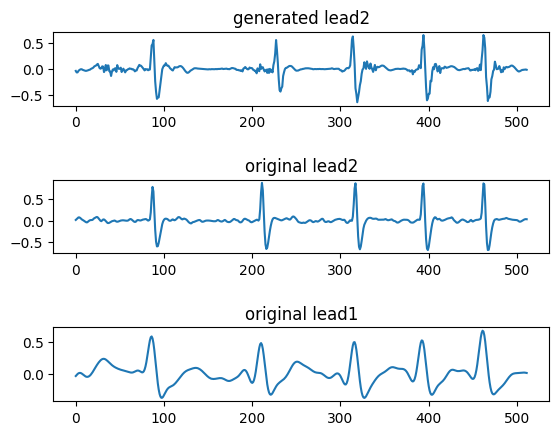

In [22]:
import matplotlib.pyplot as plt

for i in range(1, 5) :
    fig, axs = plt.subplots(3, 1)
    fig.subplots_adjust(hspace=1)
    
    axs[0].plot(fake_ecgs[i])
    axs[0].set_title('generated lead2')
    
    axs[1].plot(real_ecg2[i])
    axs[1].set_title('original lead2')
    
    axs[2].plot(real_ecg1[i])
    axs[2].set_title('original lead1')
    
    plt.show()

In [ ]:
plt.plot(fake_ecgs[1])